# Classification of Text Using Single Input

Takes a CSV or Panda Dataframe with 'Name' and 'Gender', trains a model to predict Gender based on Name using a Recurrent Neural Network

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [2]:
# Get training data
df = pd.read_csv('../../inputs/names.csv')
df.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [3]:
# Some names are both male and female
print('Total names (%.0f) vs unique names (%.0f)' %(len(df), len(df['Name'].unique())))
# Drop duplicates (a name that is both male and female does not need to be predicted as it will always be correct)
df = df.drop_duplicates(subset=['Name'], keep=random.choice(['first', 'last']))

Total names (10131) vs unique names (9543)


In [4]:
# Change names to lower case
df['Name'] = df['Name'].str.lower()
# Change gender enum to 0 or 1
df['Gender'] = preprocessing.LabelEncoder().fit_transform(df['Gender'])

df.head()

,Name,Gender
0,aamir,1
2,aaron,1
3,abagael,0
4,abagail,0
5,abbe,0


In [5]:
# Create a counter to keep track of unique characters in the names
char_counter = Counter(''.join(df['Name']))
# Create a dictionary to map each character to a unique integer
char_to_int = {char: i+1 for i, char in enumerate(char_counter.keys())}
# Add a special character for padding
char_to_int['<pad>'] = 0
# Create a dictionary to map each integer back to its corresponding character
int_to_char = {i: char for char, i in char_to_int.items()}
# Convert each name to a list of integers, using the character-to-integer mapping
df['Name'] = df['Name'].apply(lambda name: [char_to_int[char] for char in name])
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2)

train_data.head()

,Name,Gender
7093,"[6, 3, 9, 18, 16, 1]",0
1848,"[17, 10, 9, 25, 1]",0
7274,"[5, 5, 6, 1]",0
9365,"[12, 5, 4, 11]",1
189,"[1, 10, 9, 17, 3, 1]",0


Epoch 1 (5%), Loss: 0.400
Epoch 2 (10%), Loss: 0.382
Epoch 3 (15%), Loss: 0.370
Epoch 4 (20%), Loss: 0.361
Epoch 5 (25%), Loss: 0.352
Epoch 6 (30%), Loss: 0.346
Epoch 7 (35%), Loss: 0.340
Epoch 8 (40%), Loss: 0.334
Epoch 9 (45%), Loss: 0.330
Epoch 10 (50%), Loss: 0.326
Epoch 11 (55%), Loss: 0.322
Epoch 12 (60%), Loss: 0.319
Epoch 13 (65%), Loss: 0.315
Epoch 14 (70%), Loss: 0.312
Epoch 15 (75%), Loss: 0.310
Epoch 16 (80%), Loss: 0.307
Epoch 17 (85%), Loss: 0.305
Epoch 18 (90%), Loss: 0.303
Epoch 19 (95%), Loss: 0.301
Epoch 20 (100%), Loss: 0.300


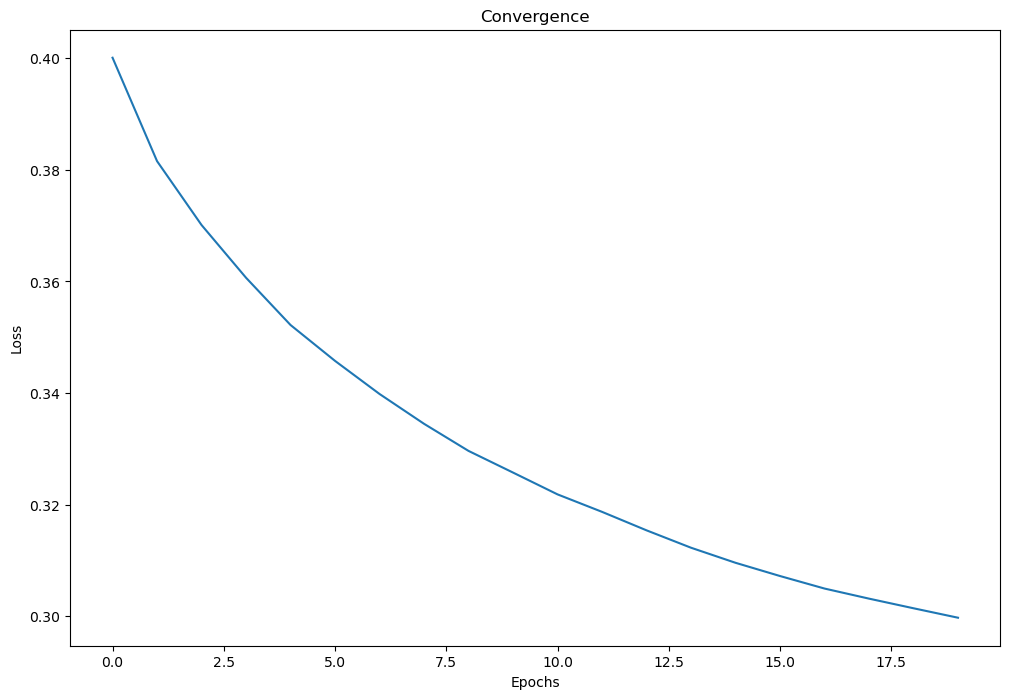

In [6]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output[0])
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Initialize the model, optimizer, and loss function
model = RNN(len(char_to_int), 128, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define the model training function
def train(model, optimizer, criterion, train_data, num_epochs):
    total_loss = 0
    plot_losses = []
    model.train() # Put the model in "training mode", which turns on dropout and batch normalization
    for epoch in range(1, num_epochs+1):
        iter_loss = 0
        for iter, row in train_data.iterrows():
            name = row['Name']
            gender = row['Gender']
            hidden = model.init_hidden().to(device)
            for char in name:
                input = torch.tensor([[char]]).to(device)
                output, hidden = model(input, hidden)
            loss = criterion(output, torch.tensor([gender]).to(device))
            iter_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += iter_loss
        plot_losses.append(total_loss/(iter*epoch))
        percentComplete = epoch/num_epochs*100
        print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/(iter*epoch):.3f}')
    return plot_losses

# Train the model
plot_losses = train(model, optimizer, criterion, train_data, num_epochs=20)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [7]:
# Test the model
def test(model, test_data, int_to_char):
    correct = 0
    model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
    for _, row in test_data.iterrows():
        x = row['Name']
        y = row['Gender']
        hidden = model.init_hidden().to(device)
        for char in x:
            input = torch.tensor([[char]]).to(device)
            output, hidden = model(input, hidden)
        y_predicted = torch.argmax(output).item()
        if y_predicted == y:
            correct += 1
    accuracy = correct / len(test_data) * 100
    print(f"Test Accuracy: {accuracy:>0.1f}%")

test(model, test_data, int_to_char)

Test Accuracy: 83.7%
